In [10]:
import pandas as pd

train_data = pd.read_csv("./data/train.csv")
test_data = pd.read_csv("./data/test.csv")

print(train_data.info()) # 6,995,055개의 데이터
print(test_data.info()) # 1,747,688개의 데이터

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6995056 entries, 0 to 6995055
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   ID      object
 1   URL     object
 2   label   int64 
dtypes: int64(1), object(2)
memory usage: 160.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1747689 entries, 0 to 1747688
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   ID      object
 1   URL     object
dtypes: object(2)
memory usage: 26.7+ MB
None


In [11]:
train_data.head()

,ID,URL,label
0,TRAIN_0000000,poznan[.]wuoz[.]gov[.]pl,0
1,TRAIN_0000001,vill[.]okawa[.]kochi[.]jp,0
2,TRAIN_0000002,nationalfinance[.]co[.]om,0
3,TRAIN_0000003,town[.]ozora[.]hokkaido[.]jp,0
4,TRAIN_0000004,open24[.]ie-news[.]irish/online/Login,1


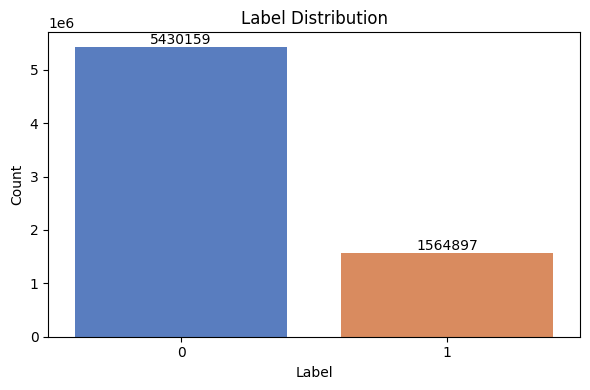

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  

ax = sns.countplot(
    x='label',
    hue='label',
    data=train_data,
    palette='muted',
    legend=False,  
)

plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,   # 막대 중앙 x 위치
        p.get_height() + 0.2,            # 막대 위쪽 y 위치
        f'{int(p.get_height())}',        # 개수 표시
        ha='center', va='bottom'
    )

plt.tight_layout()
plt.show()

In [13]:
train_data['URL'] = train_data['URL'].str.replace('[.]', '.')
test_data['URL'] = test_data['URL'].str.replace('[.]', '.')

In [14]:
import re
import string
import pandas as pd
import math
from collections import Counter

# -----------------------------------
# URL normalize (핵심!)
# -----------------------------------

def normalize_url(url):
    if not re.match(r'^https?://', url):
        return 'http://' + url
    return url

# -----------------------------------
# Helper functions
# -----------------------------------

def count_digits(url):
    return sum(char.isdigit() for char in url)

def count_special_chars(url):
    return sum(char in string.punctuation for char in url)

def extract_domain(url):
    match = re.search(r'://([^/]+)', url)
    return match.group(1) if match else None

def has_digit(s):
    return any(c.isdigit() for c in str(s))

def count_unique_chars(url):
    return len(set(url))

def extract_tld(url):
    match = re.search(r'\.([a-zA-Z]{2,10})(?:/|$)', url)
    return match.group(1).lower() if match else None

def path_part(url):
    match = re.search(r'[^/]+/(.*)', url)
    return match.group(1) if match else ""

def query_part(url):
    match = re.search(r'\?(.*)', url)
    return match.group(1) if match else ""

def calculate_entropy(url):
    counter = Counter(url)
    length = len(url)
    entropy = 0
    for count in counter.values():
        p = count / length
        entropy -= p * math.log2(p)
    return entropy

def check_randomness(url):
    entropy = calculate_entropy(url)
    
    # 연속된 동일 문자 최대 길이
    max_consecutive = current = 1
    for i in range(1, len(url)):
        if url[i].isalnum() and url[i-1].isalnum() and url[i].lower() == url[i-1].lower():
            current += 1
            max_consecutive = max(max_consecutive, current)
        else:
            current = 1
    
    # 숫자 ↔ 문자 전환 횟수
    transitions = 0
    for i in range(1, len(url)):
        if (url[i-1].isdigit() and url[i].isalpha()) or (url[i-1].isalpha() and url[i].isdigit()):
            transitions += 1
    
    # 무작위성 점수 (0~1 정규화)
    entropy_score     = min(entropy / 5.0, 1.0)
    consecutive_score = min(max_consecutive / 10.0, 1.0)
    transition_score  = min(transitions / 10.0, 1.0)
    
    randomness_score = (entropy_score * 0.5 +
                        (1 - consecutive_score) * 0.3 +
                        transition_score * 0.2)
    
    return randomness_score


# -----------------------------------
# Feature Engineering
# -----------------------------------

def add_url_features(df):
    df['URL_norm'] = df['URL'].apply(normalize_url)

    # 길이 기반
    df['length'] = df['URL'].str.len()
    df['subdomain_count'] = df['URL'].str.split('.').str.len()
    df['num_digits'] = df['URL'].apply(count_digits)
    df['num_special_chars'] = df['URL'].apply(count_special_chars)
    df['unique_chars'] = df['URL'].apply(count_unique_chars)

    # domain
    df['domain'] = df['URL_norm'].apply(extract_domain)
    df['domain_length'] = df['domain'].astype(str).str.len()
    df['domain_has_digit'] = df['domain'].apply(has_digit)
    df['num_hyphens'] = df['URL'].str.count('-')
    df['num_underscores'] = df['URL'].str.count('_')

    # IP URL
    df['is_ip_url'] = df['URL_norm'].str.contains(r'^\d{1,3}(\.\d{1,3}){3}')

    # http/https
    df['is_http'] = df['URL_norm'].str.startswith('http://')
    df['is_https'] = df['URL_norm'].str.startswith('https://')

    # :port
    df['has_port'] = df['URL_norm'].str.contains(r':\d{2,5}')

    # @
    df['has_at'] = df['URL_norm'].str.contains('@')

    # path & query
    df['path'] = df['URL_norm'].apply(path_part)
    df['path_length'] = df['path'].str.len()
    df['query'] = df['URL_norm'].apply(query_part)
    df['query_length'] = df['query'].str.len()
    df['num_params'] = df['query'].str.count('=')

    # tld
    df['tld'] = df['URL_norm'].apply(extract_tld)

    # 피싱 키워드
    phishing_keywords = ['login', 'secure', 'update', 'verify', 'account', 'bank',
                         'paypal', 'free', 'bonus', 'admin', 'redirect', 'auth',
                         'signin', 'server', 'click', 'immediate', 'confirm']
    df['has_phish_keyword'] = df['URL'].apply(
        lambda x: any(k in x.lower() for k in phishing_keywords)
    )

    # 무작위성 점수
    df['randomness'] = df['URL'].apply(check_randomness)

    return df


# -----------------------------------
# 실행
# -----------------------------------

train_data = add_url_features(train_data)
train_data.head()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_21644\2791093017.py:109: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['is_ip_url'] = df['URL_norm'].str.contains(r'^\d{1,3}(\.\d{1,3}){3}')


,ID,URL,label,URL_norm,length,subdomain_count,num_digits,num_special_chars,unique_chars,domain,...,has_port,has_at,path,path_length,query,query_length,num_params,tld,has_phish_keyword,randomness
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,http://poznan.wuoz.gov.pl,18,4,0,3,11,poznan.wuoz.gov.pl,...,False,False,/poznan.wuoz.gov.pl,19,,0,0,pl,False,0.600827
1,TRAIN_0000001,vill.okawa.kochi.jp,0,http://vill.okawa.kochi.jp,19,4,0,3,12,vill.okawa.kochi.jp,...,False,False,/vill.okawa.kochi.jp,20,,0,0,jp,False,0.587135
2,TRAIN_0000002,nationalfinance.co.om,0,http://nationalfinance.co.om,21,3,0,2,11,nationalfinance.co.om,...,False,False,/nationalfinance.co.om,22,,0,0,om,False,0.597280
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,http://town.ozora.hokkaido.jp,22,4,0,3,14,town.ozora.hokkaido.jp,...,False,False,/town.ozora.hokkaido.jp,23,,0,0,jp,False,0.593377
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,http://open24.ie-news.irish/online/Login,33,3,2,5,17,open24.ie-news.irish,...,False,False,/open24.ie-news.irish/online/Login,34,,0,0,irish,True,0.667245


In [15]:
import re
import string
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
import lightgbm as lgb
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

tqdm.pandas()



# =====================================================
# 1) URL normalize
# =====================================================
def normalize_url(url):
    if not re.match(r'^https?://', url):
        return 'http://' + url
    return url


# =====================================================
# 2) Feature helper functions
# =====================================================
def count_digits(url):
    return sum(char.isdigit() for char in url)

def count_special_chars(url):
    return sum(char in string.punctuation for char in url)

def extract_domain(url):
    m = re.search(r'://([^/]+)', url)
    return m.group(1) if m else None

def extract_tld(url):
    m = re.search(r'\.([a-zA-Z]{2,10})(?:/|$)', url)
    return m.group(1).lower() if m else None

def count_unique_chars(url):
    return len(set(url))

def has_digit(s):
    return any(c.isdigit() for c in str(s))

def path_part(url):
    m = re.search(r'[^/]+/(.*)', url)
    return m.group(1) if m else ""

def query_part(url):
    m = re.search(r'\?(.*)', url)
    return m.group(1) if m else ""

def calculate_entropy(url):
    counter = Counter(url)
    length = len(url)
    entropy = 0
    for count in counter.values():
        p = count / length
        entropy -= p * math.log2(p)
    return entropy

def check_randomness(url):
    entropy = calculate_entropy(url)
    
    # 연속된 동일 문자 최대 길이
    max_consecutive = current = 1
    for i in range(1, len(url)):
        if url[i].isalnum() and url[i-1].isalnum() and url[i].lower() == url[i-1].lower():
            current += 1
            max_consecutive = max(max_consecutive, current)
        else:
            current = 1
    
    # 숫자 ↔ 문자 전환 횟수
    transitions = 0
    for i in range(1, len(url)):
        if (url[i-1].isdigit() and url[i].isalpha()) or (url[i-1].isalpha() and url[i].isdigit()):
            transitions += 1
    
    # 무작위성 점수 (0~1 정규화)
    entropy_score     = min(entropy / 5.0, 1.0)
    consecutive_score = min(max_consecutive / 10.0, 1.0)
    transition_score  = min(transitions / 10.0, 1.0)
    
    randomness_score = (entropy_score * 0.5 +
                        (1 - consecutive_score) * 0.3 +
                        transition_score * 0.2)
    
    return randomness_score


# =====================================================
# 3) Feature Engineering
# =====================================================
def add_url_features(df):
    df['URL_norm'] = df['URL'].apply(normalize_url)

    df['length'] = df['URL'].str.len()
    df['subdomain_count'] = df['URL'].str.split('.').str.len()
    df['num_digits'] = df['URL'].apply(count_digits)
    df['num_special_chars'] = df['URL'].apply(count_special_chars)
    df['unique_chars'] = df['URL'].apply(count_unique_chars)

    df['domain'] = df['URL_norm'].apply(extract_domain)
    df['domain_length'] = df['domain'].astype(str).str.len()
    df['domain_has_digit'] = df['domain'].apply(has_digit)

    df['num_hyphens'] = df['URL'].str.count('-')
    df['num_underscores'] = df['URL'].str.count('_')

    df['is_ip_url'] = df['URL_norm'].str.contains(r'^\d{1,3}(\.\d{1,3}){3}')
    df['is_http'] = df['URL_norm'].str.startswith('http://')
    df['is_https'] = df['URL_norm'].str.startswith('https://')
    df['has_port'] = df['URL_norm'].str.contains(r':\d{2,5}')
    df['has_at'] = df['URL_norm'].str.contains('@')

    df['path'] = df['URL_norm'].apply(path_part)
    df['path_length'] = df['path'].str.len()
    df['query'] = df['URL_norm'].apply(query_part)
    df['query_length'] = df['query'].str.len()
    df['num_params'] = df['query'].str.count('=')

    df['tld'] = df['URL_norm'].apply(extract_tld)

    # 무작위성 점수
    df['randomness'] = df['URL'].apply(check_randomness)

    phishing_keywords = ['login', 'secure', 'update', 'verify', 'account', 'bank',
                         'paypal', 'free', 'bonus', 'admin', 'redirect', 'auth',
                         'signin', 'server', 'click', 'immediate', 'confirm']
    df['has_phish_keyword'] = df['URL'].apply(
        lambda x: any(k in x.lower() for k in phishing_keywords)
    )

    return df


# =====================================================
# 4) Feature Engineering 실행
# =====================================================
df = add_url_features(train_data.copy())

# tld 인코딩
le = LabelEncoder()
df['tld_encoded'] = le.fit_transform(df['tld'].astype(str))

exclude_cols = [
    'ID','URL','URL_norm','domain','path','query','tld','label'
]
features = [c for c in df.columns if c not in exclude_cols]

X = df[features]
y = df['label']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


import optuna
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, accuracy_score


# =====================================================
# Optuna Objective 함수 (LightGBM callbacks 적용)
# =====================================================
def objective(trial):

    params = {
        "objective": "binary",
        "boosting_type": "gbdt",
        "random_state": 42,

        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "n_estimators": 500
    }

    model = LGBMClassifier(**params)

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric="logloss",
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False)
        ]
    )

    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds)

    return f1


# =====================================================
# Optuna 실행
# =====================================================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("🔥 Best params:", study.best_params)


# =====================================================
# Best params로 최종 모델 학습
# =====================================================
best_params = study.best_params.copy()
best_params.update({
    "objective": "binary",
    "boosting_type": "gbdt",
    "random_state": 42,
    "n_estimators": 500
})

model = LGBMClassifier(**best_params)

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="logloss",
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=False)
    ]
)


# =====================================================
# 평가
# =====================================================
preds = model.predict_proba(X_valid)
acc = accuracy_score(y_valid, preds)
f1 = f1_score(y_valid, preds)

print("Validation Accuracy:", acc)
print("Validation F1:", f1)


# =====================================================
# Feature Importance
# =====================================================
lgb.plot_importance(model, max_num_features=20, height=0.4, figsize=(10, 8))
plt.title("LightGBM Feature Importance (Top 20)")
plt.show()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_21644\3807485714.py:117: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['is_ip_url'] = df['URL_norm'].str.contains(r'^\d{1,3}(\.\d{1,3}){3}')
[I 2025-11-21 02:24:38,303] A new study created in memory with name: no-name-9e7fe884-092e-42ba-8ebc-85b977c75a81


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:25:10,713] Trial 0 finished with value: 0.7995417692875646 and parameters: {'num_leaves': 242, 'max_depth': 3, 'learning_rate': 0.14996470311170257, 'min_child_samples': 50, 'subsample': 0.8755229354080253, 'subsample_freq': 5, 'colsample_bytree': 0.9674520338241691, 'reg_alpha': 0.4895237146104048, 'reg_lambda': 1.6465304512325756}. Best is trial 0 with value: 0.7995417692875646.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:26:18,370] Trial 1 finished with value: 0.8366170903613726 and parameters: {'num_leaves': 194, 'max_depth': 11, 'learning_rate': 0.036596014547256354, 'min_child_samples': 64, 'subsample': 0.5831545317674602, 'subsample_freq': 9, 'colsample_bytree': 0.6006765723782501, 'reg_alpha': 2.4408681895105233, 'reg_lambda': 2.4651511066992446}. Best is trial 1 with value: 0.8366170903613726.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:26:52,128] Trial 2 finished with value: 0.7802354568641295 and parameters: {'num_leaves': 96, 'max_depth': 3, 'learning_rate': 0.06606741683145688, 'min_child_samples': 192, 'subsample': 0.9939102945448025, 'subsample_freq': 8, 'colsample_bytree': 0.934895888182433, 'reg_alpha': 0.009983733391843996, 'reg_lambda': 1.1350793513216355}. Best is trial 1 with value: 0.8366170903613726.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:28:15,660] Trial 3 finished with value: 0.8373633469537958 and parameters: {'num_leaves': 169, 'max_depth': 11, 'learning_rate': 0.04112005678629534, 'min_child_samples': 153, 'subsample': 0.9552508432913052, 'subsample_freq': 3, 'colsample_bytree': 0.8747730016452286, 'reg_alpha': 4.027543008064819, 'reg_lambda': 0.31359876988102275}. Best is trial 3 with value: 0.8373633469537958.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:29:25,557] Trial 4 finished with value: 0.842245196849029 and parameters: {'num_leaves': 238, 'max_depth': 10, 'learning_rate': 0.07769803941694065, 'min_child_samples': 125, 'subsample': 0.6646292193651728, 'subsample_freq': 4, 'colsample_bytree': 0.6464912533598965, 'reg_alpha': 2.156124161130675, 'reg_lambda': 2.482423236910105}. Best is trial 4 with value: 0.842245196849029.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:30:25,569] Trial 5 finished with value: 0.8460181765364984 and parameters: {'num_leaves': 192, 'max_depth': 12, 'learning_rate': 0.15163545235352124, 'min_child_samples': 122, 'subsample': 0.6273472198104019, 'subsample_freq': 6, 'colsample_bytree': 0.7570480520973694, 'reg_alpha': 0.5731782250493367, 'reg_lambda': 3.7370057778030743}. Best is trial 5 with value: 0.8460181765364984.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:31:29,046] Trial 6 finished with value: 0.8464933282395507 and parameters: {'num_leaves': 204, 'max_depth': 11, 'learning_rate': 0.1683061995962949, 'min_child_samples': 104, 'subsample': 0.7153100917512829, 'subsample_freq': 10, 'colsample_bytree': 0.9202902550079173, 'reg_alpha': 3.397525187065465, 'reg_lambda': 4.518184407413702}. Best is trial 6 with value: 0.8464933282395507.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:32:01,163] Trial 7 finished with value: 0.7887852204895158 and parameters: {'num_leaves': 114, 'max_depth': 3, 'learning_rate': 0.09376452785846577, 'min_child_samples': 78, 'subsample': 0.9110804537972319, 'subsample_freq': 9, 'colsample_bytree': 0.7611780367827736, 'reg_alpha': 1.363859476883302, 'reg_lambda': 2.0870882855303172}. Best is trial 6 with value: 0.8464933282395507.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:32:48,082] Trial 8 finished with value: 0.7921422426154288 and parameters: {'num_leaves': 212, 'max_depth': 5, 'learning_rate': 0.028604865509926837, 'min_child_samples': 185, 'subsample': 0.8443409785527796, 'subsample_freq': 6, 'colsample_bytree': 0.6591599524291789, 'reg_alpha': 2.5062545745216576, 'reg_lambda': 1.4136410865354225}. Best is trial 6 with value: 0.8464933282395507.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.097573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:33:44,424] Trial 9 finished with value: 0.8441459942995868 and parameters: {'num_leaves': 149, 'max_depth': 8, 'learning_rate': 0.19375849774525297, 'min_child_samples': 101, 'subsample': 0.7903978502959627, 'subsample_freq': 10, 'colsample_bytree': 0.8489130294306703, 'reg_alpha': 0.9800721143381497, 'reg_lambda': 0.8055289416386036}. Best is trial 6 with value: 0.8464933282395507.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1681
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149


[I 2025-11-21 02:34:22,253] Trial 10 finished with value: 0.8274484978802734 and parameters: {'num_leaves': 25, 'max_depth': 8, 'learning_rate': 0.14351168335150344, 'min_child_samples': 21, 'subsample': 0.5014267274408903, 'subsample_freq': 2, 'colsample_bytree': 0.5015590292518387, 'reg_alpha': 4.792291658521696, 'reg_lambda': 4.924763428400976}. Best is trial 6 with value: 0.8464933282395507.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:35:25,729] Trial 11 finished with value: 0.8461836376902303 and parameters: {'num_leaves': 191, 'max_depth': 12, 'learning_rate': 0.1465768660542543, 'min_child_samples': 134, 'subsample': 0.687346520791495, 'subsample_freq': 7, 'colsample_bytree': 0.7802033107183659, 'reg_alpha': 3.4710183276806124, 'reg_lambda': 4.049297868564859}. Best is trial 6 with value: 0.8464933282395507.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:36:27,194] Trial 12 finished with value: 0.8452440043098752 and parameters: {'num_leaves': 157, 'max_depth': 9, 'learning_rate': 0.19677006259078073, 'min_child_samples': 143, 'subsample': 0.7251565133587131, 'subsample_freq': 7, 'colsample_bytree': 0.8387650411951466, 'reg_alpha': 3.625831838911796, 'reg_lambda': 3.7979582875284437}. Best is trial 6 with value: 0.8464933282395507.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:37:33,282] Trial 13 finished with value: 0.8459585829102629 and parameters: {'num_leaves': 215, 'max_depth': 12, 'learning_rate': 0.12253026659672152, 'min_child_samples': 94, 'subsample': 0.723156510110405, 'subsample_freq': 10, 'colsample_bytree': 0.9021208090199238, 'reg_alpha': 3.2583433111890696, 'reg_lambda': 4.892215217058566}. Best is trial 6 with value: 0.8464933282395507.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:38:19,220] Trial 14 finished with value: 0.836244234227191 and parameters: {'num_leaves': 103, 'max_depth': 6, 'learning_rate': 0.17150639146649677, 'min_child_samples': 158, 'subsample': 0.7609303786402188, 'subsample_freq': 8, 'colsample_bytree': 0.984564002733183, 'reg_alpha': 4.455458883644761, 'reg_lambda': 3.691844614414605}. Best is trial 6 with value: 0.8464933282395507.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149


[I 2025-11-21 02:38:58,264] Trial 15 finished with value: 0.836997799237717 and parameters: {'num_leaves': 55, 'max_depth': 10, 'learning_rate': 0.11333387783527314, 'min_child_samples': 122, 'subsample': 0.6568195134731409, 'subsample_freq': 1, 'colsample_bytree': 0.810461713027354, 'reg_alpha': 3.2791667716418282, 'reg_lambda': 4.287518396477002}. Best is trial 6 with value: 0.8464933282395507.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:39:58,257] Trial 16 finished with value: 0.844643796550101 and parameters: {'num_leaves': 173, 'max_depth': 12, 'learning_rate': 0.1301743932014236, 'min_child_samples': 172, 'subsample': 0.5633037291077442, 'subsample_freq': 7, 'colsample_bytree': 0.7135315984066021, 'reg_alpha': 3.144720312479133, 'reg_lambda': 3.0772509245069855}. Best is trial 6 with value: 0.8464933282395507.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-11-21 02:40:52,753] Trial 17 finished with value: 0.8453078620899612 and parameters: {'num_leaves': 133, 'max_depth': 10, 'learning_rate': 0.17174166932777096, 'min_child_samples': 29, 'subsample': 0.8046677058176344, 'subsample_freq': 8, 'colsample_bytree': 0.8123019345831002, 'reg_alpha': 3.9844378294921863, 'reg_lambda': 3.1302159771411064}. Best is trial 6 with value: 0.8464933282395507.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:41:36,199] Trial 18 finished with value: 0.8362178295570234 and parameters: {'num_leaves': 220, 'max_depth': 6, 'learning_rate': 0.17412789412655832, 'min_child_samples': 83, 'subsample': 0.6994453271551857, 'subsample_freq': 5, 'colsample_bytree': 0.922942648084445, 'reg_alpha': 1.8594585706406574, 'reg_lambda': 4.348589392200343}. Best is trial 6 with value: 0.8464933282395507.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149


[I 2025-11-21 02:42:49,626] Trial 19 finished with value: 0.8088109100966618 and parameters: {'num_leaves': 249, 'max_depth': 11, 'learning_rate': 0.007121903269356147, 'min_child_samples': 136, 'subsample': 0.6070838784981555, 'subsample_freq': 10, 'colsample_bytree': 0.7318060654873251, 'reg_alpha': 2.7649117377487222, 'reg_lambda': 4.272038799285427}. Best is trial 6 with value: 0.8464933282395507.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:43:46,768] Trial 20 finished with value: 0.8406631045348678 and parameters: {'num_leaves': 180, 'max_depth': 9, 'learning_rate': 0.0965692992982641, 'min_child_samples': 113, 'subsample': 0.5464065465030297, 'subsample_freq': 7, 'colsample_bytree': 0.5611279737592769, 'reg_alpha': 4.0799692075979666, 'reg_lambda': 3.2412544368856286}. Best is trial 6 with value: 0.8464933282395507.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:44:46,932] Trial 21 finished with value: 0.8463375851221957 and parameters: {'num_leaves': 198, 'max_depth': 12, 'learning_rate': 0.1536040539974834, 'min_child_samples': 109, 'subsample': 0.6401694032359729, 'subsample_freq': 6, 'colsample_bytree': 0.7885196821903161, 'reg_alpha': 1.6341672614930896, 'reg_lambda': 3.8521545826613486}. Best is trial 6 with value: 0.8464933282395507.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:45:49,695] Trial 22 finished with value: 0.8468889184625462 and parameters: {'num_leaves': 207, 'max_depth': 12, 'learning_rate': 0.1597146319357941, 'min_child_samples': 98, 'subsample': 0.6775946127862482, 'subsample_freq': 4, 'colsample_bytree': 0.7953364835134243, 'reg_alpha': 1.6016663230775445, 'reg_lambda': 4.3859459948995445}. Best is trial 22 with value: 0.8468889184625462.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:46:56,438] Trial 23 finished with value: 0.8467322351477019 and parameters: {'num_leaves': 219, 'max_depth': 11, 'learning_rate': 0.17749265095637737, 'min_child_samples': 103, 'subsample': 0.6416196293657609, 'subsample_freq': 4, 'colsample_bytree': 0.6809949494514387, 'reg_alpha': 1.4937433476003599, 'reg_lambda': 4.720065937586828}. Best is trial 22 with value: 0.8468889184625462.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:48:01,527] Trial 24 finished with value: 0.8456049774037496 and parameters: {'num_leaves': 229, 'max_depth': 9, 'learning_rate': 0.18221985627300158, 'min_child_samples': 65, 'subsample': 0.7437371685897001, 'subsample_freq': 4, 'colsample_bytree': 0.6876082701754638, 'reg_alpha': 1.2043180465991041, 'reg_lambda': 4.65916410126928}. Best is trial 22 with value: 0.8468889184625462.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:49:16,168] Trial 25 finished with value: 0.8467027610098119 and parameters: {'num_leaves': 254, 'max_depth': 11, 'learning_rate': 0.16362064319321545, 'min_child_samples': 89, 'subsample': 0.7845916884534748, 'subsample_freq': 3, 'colsample_bytree': 0.6051525257489205, 'reg_alpha': 1.9163749766798641, 'reg_lambda': 4.594095668081593}. Best is trial 22 with value: 0.8468889184625462.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:50:29,472] Trial 26 finished with value: 0.8456494962356067 and parameters: {'num_leaves': 249, 'max_depth': 10, 'learning_rate': 0.13254120210695677, 'min_child_samples': 44, 'subsample': 0.7843277499732717, 'subsample_freq': 3, 'colsample_bytree': 0.6066968714304674, 'reg_alpha': 1.8892094983959986, 'reg_lambda': 3.43130129212227}. Best is trial 22 with value: 0.8468889184625462.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:51:41,431] Trial 27 finished with value: 0.8464847667462047 and parameters: {'num_leaves': 230, 'max_depth': 11, 'learning_rate': 0.18918685456633633, 'min_child_samples': 87, 'subsample': 0.8254962936973662, 'subsample_freq': 3, 'colsample_bytree': 0.5452647675025265, 'reg_alpha': 0.8095499673114337, 'reg_lambda': 4.912846148124744}. Best is trial 22 with value: 0.8468889184625462.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:52:32,244] Trial 28 finished with value: 0.8363664182127662 and parameters: {'num_leaves': 254, 'max_depth': 7, 'learning_rate': 0.1124259862166826, 'min_child_samples': 72, 'subsample': 0.6722522440556378, 'subsample_freq': 4, 'colsample_bytree': 0.6862731402184626, 'reg_alpha': 1.5282712941173295, 'reg_lambda': 2.814532964893393}. Best is trial 22 with value: 0.8468889184625462.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:53:44,552] Trial 29 finished with value: 0.8462987533061518 and parameters: {'num_leaves': 237, 'max_depth': 10, 'learning_rate': 0.16200312422083563, 'min_child_samples': 51, 'subsample': 0.7628966074982061, 'subsample_freq': 2, 'colsample_bytree': 0.6286651095035363, 'reg_alpha': 0.22847503710000816, 'reg_lambda': 4.5948960120272995}. Best is trial 22 with value: 0.8468889184625462.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:54:56,969] Trial 30 finished with value: 0.8443730003793541 and parameters: {'num_leaves': 254, 'max_depth': 9, 'learning_rate': 0.13832887753891712, 'min_child_samples': 49, 'subsample': 0.8698469967089538, 'subsample_freq': 5, 'colsample_bytree': 0.5704958021063402, 'reg_alpha': 2.246110667631521, 'reg_lambda': 1.888851539021673}. Best is trial 22 with value: 0.8468889184625462.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:56:03,213] Trial 31 finished with value: 0.8460743122914397 and parameters: {'num_leaves': 207, 'max_depth': 11, 'learning_rate': 0.1621889316914143, 'min_child_samples': 99, 'subsample': 0.7080655852013976, 'subsample_freq': 4, 'colsample_bytree': 0.6967775285253067, 'reg_alpha': 2.8851079146416936, 'reg_lambda': 4.530321721582959}. Best is trial 22 with value: 0.8468889184625462.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:57:11,040] Trial 32 finished with value: 0.8472903000721942 and parameters: {'num_leaves': 224, 'max_depth': 11, 'learning_rate': 0.18211440927611353, 'min_child_samples': 89, 'subsample': 0.6000124824751837, 'subsample_freq': 2, 'colsample_bytree': 0.9486438487563743, 'reg_alpha': 1.9441540560149446, 'reg_lambda': 4.27968697961268}. Best is trial 32 with value: 0.8472903000721942.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:58:18,720] Trial 33 finished with value: 0.8472484047157862 and parameters: {'num_leaves': 221, 'max_depth': 11, 'learning_rate': 0.18179860885785498, 'min_child_samples': 87, 'subsample': 0.6085712916623457, 'subsample_freq': 2, 'colsample_bytree': 0.9616382485215786, 'reg_alpha': 1.8800014001643546, 'reg_lambda': 4.082592191472177}. Best is trial 32 with value: 0.8472903000721942.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 02:59:16,997] Trial 34 finished with value: 0.8474826802599861 and parameters: {'num_leaves': 223, 'max_depth': 12, 'learning_rate': 0.18374459071709673, 'min_child_samples': 63, 'subsample': 0.5923930701879776, 'subsample_freq': 1, 'colsample_bytree': 0.9493725222718381, 'reg_alpha': 1.1462552437187723, 'reg_lambda': 4.109620495976435}. Best is trial 34 with value: 0.8474826802599861.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149


[I 2025-11-21 03:00:09,543] Trial 35 finished with value: 0.8471297423806686 and parameters: {'num_leaves': 179, 'max_depth': 12, 'learning_rate': 0.18360512887703123, 'min_child_samples': 66, 'subsample': 0.5920722075331876, 'subsample_freq': 1, 'colsample_bytree': 0.9580576391270721, 'reg_alpha': 0.7847911079729689, 'reg_lambda': 3.496573723772731}. Best is trial 34 with value: 0.8474826802599861.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-11-21 03:01:01,970] Trial 36 finished with value: 0.8471559601333495 and parameters: {'num_leaves': 180, 'max_depth': 12, 'learning_rate': 0.18403858669909706, 'min_child_samples': 61, 'subsample': 0.5922113438254185, 'subsample_freq': 1, 'colsample_bytree': 0.9571354561108115, 'reg_alpha': 1.0262216416447552, 'reg_lambda': 3.4530797967872067}. Best is trial 34 with value: 0.8474826802599861.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 03:02:00,189] Trial 37 finished with value: 0.8460630159484808 and parameters: {'num_leaves': 161, 'max_depth': 10, 'learning_rate': 0.19988517973226735, 'min_child_samples': 36, 'subsample': 0.5181358941799625, 'subsample_freq': 2, 'colsample_bytree': 0.992425870041568, 'reg_alpha': 1.09350116554606, 'reg_lambda': 4.059721372174418}. Best is trial 34 with value: 0.8474826802599861.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 03:02:54,871] Trial 38 finished with value: 0.8427670995131127 and parameters: {'num_leaves': 185, 'max_depth': 12, 'learning_rate': 0.06687439814646641, 'min_child_samples': 55, 'subsample': 0.5730817092506579, 'subsample_freq': 1, 'colsample_bytree': 0.9565466808821954, 'reg_alpha': 0.040959040741293196, 'reg_lambda': 2.8409252136063445}. Best is trial 34 with value: 0.8474826802599861.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1681
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149


[I 2025-11-21 03:03:47,592] Trial 39 finished with value: 0.8461305731658192 and parameters: {'num_leaves': 136, 'max_depth': 11, 'learning_rate': 0.18712703257171132, 'min_child_samples': 12, 'subsample': 0.5399509925931459, 'subsample_freq': 2, 'colsample_bytree': 0.888113470447068, 'reg_alpha': 0.3731465843991352, 'reg_lambda': 4.043974326135971}. Best is trial 34 with value: 0.8474826802599861.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 03:04:46,604] Trial 40 finished with value: 0.8469617106261089 and parameters: {'num_leaves': 232, 'max_depth': 10, 'learning_rate': 0.18274296265152032, 'min_child_samples': 78, 'subsample': 0.6102145797272878, 'subsample_freq': 1, 'colsample_bytree': 0.9433783291947023, 'reg_alpha': 2.2328119745030195, 'reg_lambda': 2.7249339114968603}. Best is trial 34 with value: 0.8474826802599861.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-11-21 03:05:38,062] Trial 41 finished with value: 0.8475340116966739 and parameters: {'num_leaves': 175, 'max_depth': 12, 'learning_rate': 0.18813850584511735, 'min_child_samples': 64, 'subsample': 0.5887095603991842, 'subsample_freq': 1, 'colsample_bytree': 0.9666264140153266, 'reg_alpha': 0.6944274077693666, 'reg_lambda': 3.5029278475752497}. Best is trial 41 with value: 0.8475340116966739.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-11-21 03:06:39,855] Trial 42 finished with value: 0.8479713743951425 and parameters: {'num_leaves': 200, 'max_depth': 12, 'learning_rate': 0.19480352688892785, 'min_child_samples': 57, 'subsample': 0.6196603687346978, 'subsample_freq': 2, 'colsample_bytree': 0.9733093432456372, 'reg_alpha': 0.6646422404982602, 'reg_lambda': 3.543116747180977}. Best is trial 42 with value: 0.8479713743951425.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 03:07:43,240] Trial 43 finished with value: 0.8472274039989498 and parameters: {'num_leaves': 201, 'max_depth': 11, 'learning_rate': 0.19497840140514092, 'min_child_samples': 75, 'subsample': 0.6182972578168434, 'subsample_freq': 2, 'colsample_bytree': 0.9067520971641079, 'reg_alpha': 0.5140068041150618, 'reg_lambda': 4.060709975235647}. Best is trial 42 with value: 0.8479713743951425.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-11-21 03:08:45,295] Trial 44 finished with value: 0.8468868442782959 and parameters: {'num_leaves': 221, 'max_depth': 12, 'learning_rate': 0.15317728804247296, 'min_child_samples': 40, 'subsample': 0.5512656329640095, 'subsample_freq': 3, 'colsample_bytree': 0.8718494754080487, 'reg_alpha': 1.2779645021234851, 'reg_lambda': 2.2128708339790073}. Best is trial 42 with value: 0.8479713743951425.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 03:09:15,503] Trial 45 finished with value: 0.8063296935540684 and parameters: {'num_leaves': 161, 'max_depth': 3, 'learning_rate': 0.19713765991810578, 'min_child_samples': 69, 'subsample': 0.5736875332897575, 'subsample_freq': 2, 'colsample_bytree': 0.994314881214938, 'reg_alpha': 0.6598560436563694, 'reg_lambda': 3.6673695124164594}. Best is trial 42 with value: 0.8479713743951425.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-21 03:10:11,269] Trial 46 finished with value: 0.8474015821489099 and parameters: {'num_leaves': 199, 'max_depth': 11, 'learning_rate': 0.17399079146289156, 'min_child_samples': 60, 'subsample': 0.6498341718039049, 'subsample_freq': 1, 'colsample_bytree': 0.9373347135441445, 'reg_alpha': 2.5171849146378147, 'reg_lambda': 0.3535537414999901}. Best is trial 42 with value: 0.8479713743951425.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-11-21 03:11:04,607] Trial 47 finished with value: 0.8481801750167024 and parameters: {'num_leaves': 192, 'max_depth': 12, 'learning_rate': 0.18999069719590225, 'min_child_samples': 29, 'subsample': 0.6403685292254573, 'subsample_freq': 1, 'colsample_bytree': 0.9327177133051807, 'reg_alpha': 2.5093831319333324, 'reg_lambda': 0.34576757773720757}. Best is trial 47 with value: 0.8481801750167024.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149


[I 2025-11-21 03:11:58,309] Trial 48 finished with value: 0.8474146405513314 and parameters: {'num_leaves': 190, 'max_depth': 12, 'learning_rate': 0.17103356975139428, 'min_child_samples': 29, 'subsample': 0.639408819759225, 'subsample_freq': 1, 'colsample_bytree': 0.9269309738252514, 'reg_alpha': 2.5171943732258084, 'reg_lambda': 0.3057673037611323}. Best is trial 47 with value: 0.8481801750167024.


[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149


[I 2025-11-21 03:12:49,852] Trial 49 finished with value: 0.8465986018623415 and parameters: {'num_leaves': 147, 'max_depth': 12, 'learning_rate': 0.19031464125671133, 'min_child_samples': 28, 'subsample': 0.5242789921944353, 'subsample_freq': 1, 'colsample_bytree': 0.8696792441887048, 'reg_alpha': 2.864774041839413, 'reg_lambda': 0.09497379748958351}. Best is trial 47 with value: 0.8481801750167024.


🔥 Best params: {'num_leaves': 192, 'max_depth': 12, 'learning_rate': 0.18999069719590225, 'min_child_samples': 29, 'subsample': 0.6403685292254573, 'subsample_freq': 1, 'colsample_bytree': 0.9327177133051807, 'reg_alpha': 2.5093831319333324, 'reg_lambda': 0.34576757773720757}
[LightGBM] [Info] Number of positive: 1251917, number of negative: 4344127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 5596044, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223715 -> initscore=-1.244149
[LightGBM] [Info] Start training from score -1.244149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

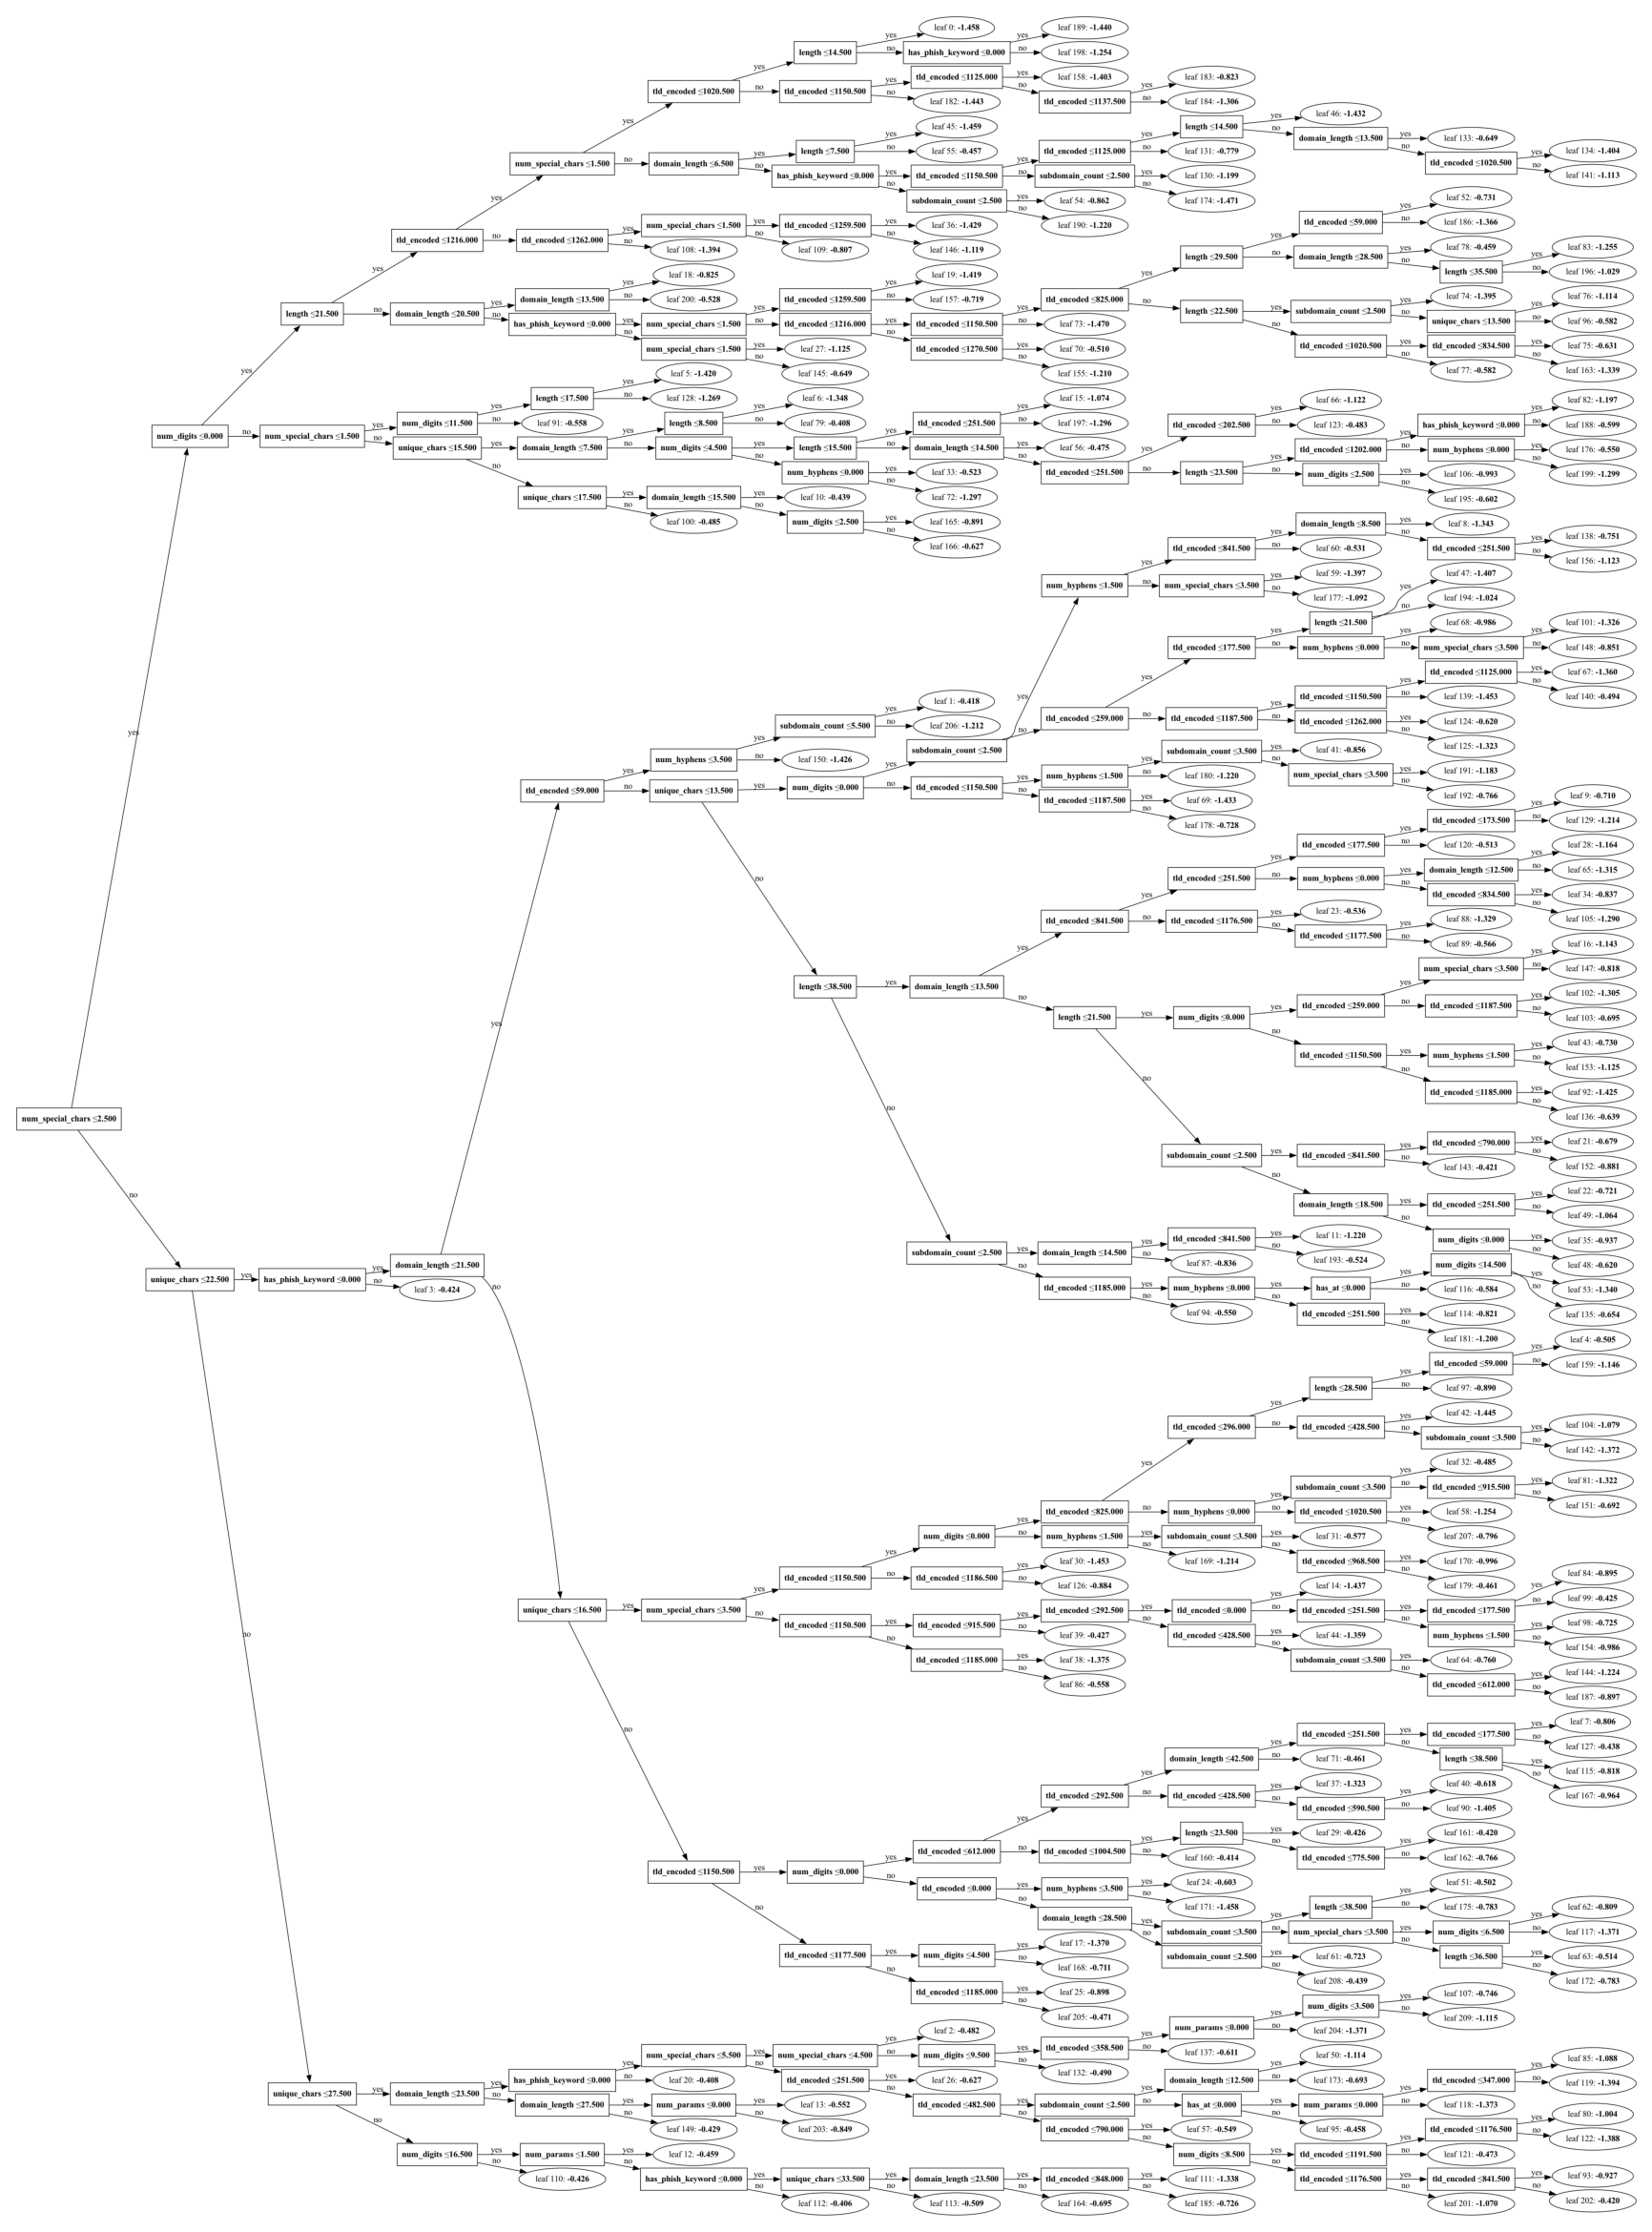

In [ ]:
lgb.plot_tree(model, tree_index=0, figsize=(30, 20), dpi=150)
plt.show()

In [16]:
# ------------------------------
# 1) test feature engineering
# ------------------------------
test_df = add_url_features(test_data.copy())

# ------------------------------
# 2) TLD 처리 (unseen → unknown)
# ------------------------------
test_df['tld_fixed'] = test_df['tld'].astype(str).apply(
    lambda x: x if x in le.classes_ else "unknown"
)

# unknown 추가 후 re-fit
new_classes = list(le.classes_)
if "unknown" not in new_classes:
    new_classes.append("unknown")
le.fit(new_classes)

test_df['tld_encoded'] = le.transform(test_df['tld_fixed'])

# ------------------------------
# 3) feature 리스트는 train에서 그대로 불러옴
# ------------------------------

X_test = test_df[features]

# ------------------------------
# 4) predict
# ------------------------------
test_pred = model.predict_proba(X_test)[:, 1]

# ------------------------------
# 5) submission 생성
# ------------------------------
submission = pd.DataFrame({
    'ID': test_df['ID'],
    'probability': test_pred 
})

submission.to_csv("submission.csv", index=False)
submission.head()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_21644\3807485714.py:117: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['is_ip_url'] = df['URL_norm'].str.contains(r'^\d{1,3}(\.\d{1,3}){3}')


,ID,probability
0,TEST_0000000,0.069680
1,TEST_0000001,0.059115
2,TEST_0000002,0.002317
3,TEST_0000003,0.000809
4,TEST_0000004,0.040524
